# Test SQL queries with Claude


In [1]:
anthropic_api_key = ""
huggingface_token = "" # provide your own token/key 

In [2]:
import torch
import asyncio
import os
import time
import json
import anthropic
import sqlite3
from huggingface_hub import login
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
import evaluate

# huggingface login
login(token=huggingface_token)

# set up the anthropic api client
async_client = anthropic.AsyncAnthropic(
    api_key=anthropic_api_key,  # Your Anthropic API key
    
    # Optional 
    base_url="https://api.anthropic.com",  # Default API endpoint
    timeout=60,  # Request timeout in seconds
    max_retries=2,  # Number of times to retry failed requests
    default_headers=None,  # Additional headers to include in requests
)
claude = "claude-3-7-sonnet-20250219"
evaluation_metrics = {}

test_data = load_dataset("b-mc2/sql-create-context", split='train[-10%:]')

In [3]:
# async function to query claude
async def ask_claude_async(question, schema, label):
    prompt = f"""Here is the schema for a database:
{schema}
Given this schema, can you output a SQL query to answer the following question? 
Only output the SQL query, use double quotes instead of single quotes in the query, and no markdown formatting or newline characters.
Question: {question}
"""
    try:
        response = await async_client.messages.create(
            model=claude,
            max_tokens=512,
            messages=[{
                "role": 'user', 
                "content": prompt
            }]
        )
        return (question, response.content[0].text, label)

    except Exception as e:
        print(f"Error querying API: {e}")
        return (question, "", label)

# process a batch of queries concurrently
async def process_batch(batch_data):
    tasks = [ask_claude_async(example['question'], 
                              example['context'], 
                              example['answer']) for example in batch_data]
    
    return await asyncio.gather(*tasks)

# process the dataset in batches
async def process_dataset(test_data, batch_size=4):
    all_responses = []
    total_batches = (len(test_data) + batch_size - 1) // batch_size 

    # use select method to batch dataset
    for batch_num in range(total_batches):
        start_idx = batch_num * batch_size
        end_idx = min(start_idx + batch_size, len(test_data))
        
        # get the batch data
        batch_data = test_data.select(range(start_idx,end_idx))
        
        print(f"Processing batch {batch_num+1}/{total_batches}")
        batch_responses = await process_batch(batch_data)

        # make dictionary format from returned data
        keys = ['question', 'prediction', 'label']
        new_responses = [dict(zip(keys, tup)) for tup in batch_responses]
        all_responses.extend([new_responses])

        # save stuff in case anthropic gets mad
        with open("claude_responses.jsonl", "a") as f:
            for item in new_responses:
                f.write(json.dumps(item) + "\n")
        
        # small delay to avoid rate limits
        if batch_num < total_batches - 1:
            await asyncio.sleep(61) # wait a minute to meet rate limit
    
    return all_responses


async def run(data):
    # process test data with asyncio
    start_time = time.time()
    
    with open("claude_responses.jsonl", "r") as f:
        responses = [json.loads(line) for line in f]
    print(f"Checked for claude_responses.jsonl, found {len(responses)} responses!")
    if data.num_rows < len(responses):
        data = data.select(range(len(responses, data.num_rows)))
        
        results = await process_dataset(test_data=data, batch_size=25) # rate limit per minute
        
        final_time = time.time() - start_time
        print(f"\nCompleted {len(results)} queries in {final_time:.2f} seconds")
    else:
        results = responses
        final_time = 21206.04
        
    '''
    Error querying API: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 
    'message': 'This request would exceed the rate limit for your organization 
    (REDACTED) of 50 requests per minute. For details, refer to: 
    https://docs.anthropic.com/en/api/rate-limits. You can see the response headers for current 
    usage. Please reduce the prompt length or the maximum tokens requested, or try again later. 
    You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options 
    for a rate limit increase.'}}
    '''
    predictions = [result['prediction'] for result in results]
    labels = [result['label'] for result in results]
    
    # evaluate the results
    exact_match = evaluate.load("exact_match")
    rouge = evaluate.load("rouge")
    sacrebleu = evaluate.load("sacrebleu")

    metrics = {
        "exact_match_strict": exact_match.compute(predictions=predictions, references=labels)["exact_match"],
        "exact_match_relaxed": exact_match.compute(predictions=predictions, 
                                                   references=labels,
                                                   ignore_case=True,
                                                   ignore_punctuation=True)["exact_match"],
        "rouge2": rouge.compute(predictions=predictions, references=labels)["rouge2"],
        "bleu": sacrebleu.compute(predictions=predictions, references=labels)["score"],
        "inference_time": final_time
    }

    return metrics, results


In [4]:
# jupyter notebook execution
import nest_asyncio
nest_asyncio.apply()  # allows asyncio.run() in jupyter

# run sql test dataset
claude_metrics, results = asyncio.run(run(test_data #.select(range(0,120,4))
                                         )) # use select method for testing
evaluation_metrics[claude] = claude_metrics
print(claude_metrics)

Checked for claude_responses.jsonl, found 7858 responses!
{'exact_match_strict': 0.30885721557648255, 'exact_match_relaxed': 0.6635276151692543, 'rouge2': 0.9125765505521157, 'bleu': 76.36535606324205, 'inference_time': 21206.04}


In [5]:
for result in results[:10]:
    print('Question:   ' + result['question'])
    print('Prediction: ' + result['prediction'])
    print('Label:      ' + result['label'])
    print('////////////////////////////////\n')

Question:   What is the Home team at the Lincoln City Away game?
Prediction: SELECT home_team FROM table_name_80 WHERE away_team = "Lincoln City"
Label:      SELECT home_team FROM table_name_80 WHERE away_team = "lincoln city"
////////////////////////////////

Question:   What is the Away team at the game with a Score of 1 – 0 and Attendance of 1,791?
Prediction: SELECT away_team FROM table_name_4 WHERE score = "1 – 0" AND attendance = "1,791"
Label:      SELECT away_team FROM table_name_4 WHERE score = "1 – 0" AND attendance = "1,791"
////////////////////////////////

Question:   What is the Home team of the game with a Score of 2 – 2?
Prediction: SELECT home_team FROM table_name_98 WHERE score = "2 – 2"
Label:      SELECT home_team FROM table_name_98 WHERE score = "2 – 2"
////////////////////////////////

Question:   What is the Attendance of the game with a Score of 0 – 0?
Prediction: SELECT attendance FROM table_name_94 WHERE score = "0 – 0"
Label:      SELECT attendance FROM table

In [6]:
model_info = [{'name': 'codet5-base-sql-create-context', 'path': 'finetuned/codet5-base-sql-create-context', 'batch_size': 16}]

dataset = DatasetDict({ 'test': test_data })

def format_dataset(example):
    return {'input': 'schema: \n' + example['context'][:420] + '\n\ntranslate to SQL: ' + example['question'], 'target': example['answer']}

formatted_test_dataset = dataset.map(format_dataset, remove_columns=dataset['test'].column_names)

print("DatasetDict class details: \n", formatted_test_dataset, "\n", "First formatted example: \n", formatted_test_dataset['test'][0])


# function to process testing data for finetuned models
def new_testing_pipeline():
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")

    # Metric calculation 
    # Exact Match https://huggingface.co/spaces/evaluate-metric/exact_match
    # ROUGE2 score https://huggingface.co/spaces/evaluate-metric/rouge
    # BLEU score https://huggingface.co/spaces/evaluate-metric/sacrebleu
    exact_match = evaluate.load("exact_match")
    rouge = evaluate.load("rouge")
    sacrebleu = evaluate.load("sacrebleu")

    metrics_dict = {}

    for info in model_info:
        
        path = info['path']

        tokenizer = AutoTokenizer.from_pretrained(path)
        model = AutoModelForSeq2SeqLM.from_pretrained(path)

        model.to(device)

        def translate_to_sql(batch):    
            inputs = tokenizer(batch['input'], truncation=True, padding='max_length', max_length=256, return_tensors='pt').to(device)
            input_ids = inputs.input_ids
            attention_mask = inputs.attention_mask
            output = model.generate(input_ids, attention_mask=attention_mask, max_length=256)
            predictions = [tokenizer.decode(o, skip_special_tokens=True) for o in output]
            
            return  {'prediction': predictions, 'label': batch['target']}

        # time the inference process by mapping to the DatasetDict
        start = time.time()
        
        results = formatted_test_dataset.map(translate_to_sql, 
                                             remove_columns=formatted_test_dataset['test'].column_names, 
                                             batched=True,
                                             batch_size=128)

        end = time.time()

        predictions, labels = results['test']['prediction'], results['test']['label']
        
        metrics = {
            "exact_match_strict": exact_match.compute(predictions=predictions, references=labels)["exact_match"],
            "exact_match_relaxed": exact_match.compute(predictions=predictions, 
                                                       references=labels,
                                                       ignore_case=True,
                                                       ignore_punctuation=True)["exact_match"],
            "rouge2": rouge.compute(predictions=predictions, references=labels)["rouge2"],
            "bleu": sacrebleu.compute(predictions=predictions, references=labels)["score"],
            "inference_time": end - start
        }
        print(f'Evaluation Metrics for {path}: ', metrics)
        metrics_dict[path] = metrics

        # clean up memory
        del model
        if cuda:
            torch.cuda.empty_cache()

    return metrics_dict, results

t5_metrics, t5_results = new_testing_pipeline()

DatasetDict class details: 
 DatasetDict({
    test: Dataset({
        features: ['input', 'target'],
        num_rows: 7858
    })
}) 
 First formatted example: 
 {'input': 'schema: \nCREATE TABLE table_name_80 (home_team VARCHAR, away_team VARCHAR)\n\ntranslate to SQL: What is the Home team at the Lincoln City Away game?', 'target': 'SELECT home_team FROM table_name_80 WHERE away_team = "lincoln city"'}


Map:   0%|          | 0/7858 [00:00<?, ? examples/s]

Evaluation Metrics for finetuned/codet5-base-sql-create-context:  {'exact_match_strict': 0.8240010180707559, 'exact_match_relaxed': 0.8862305930262153, 'rouge2': 0.9825409086504779, 'bleu': 97.28652762042714, 'inference_time': 106.53001141548157}


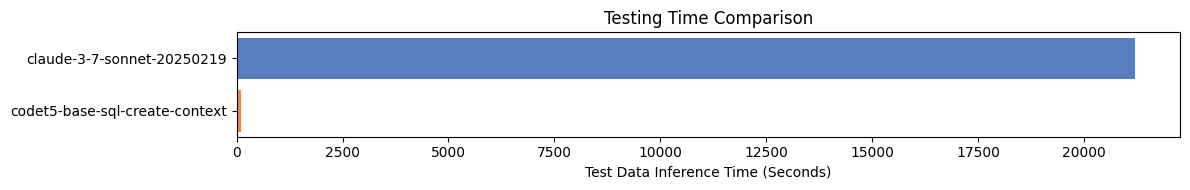

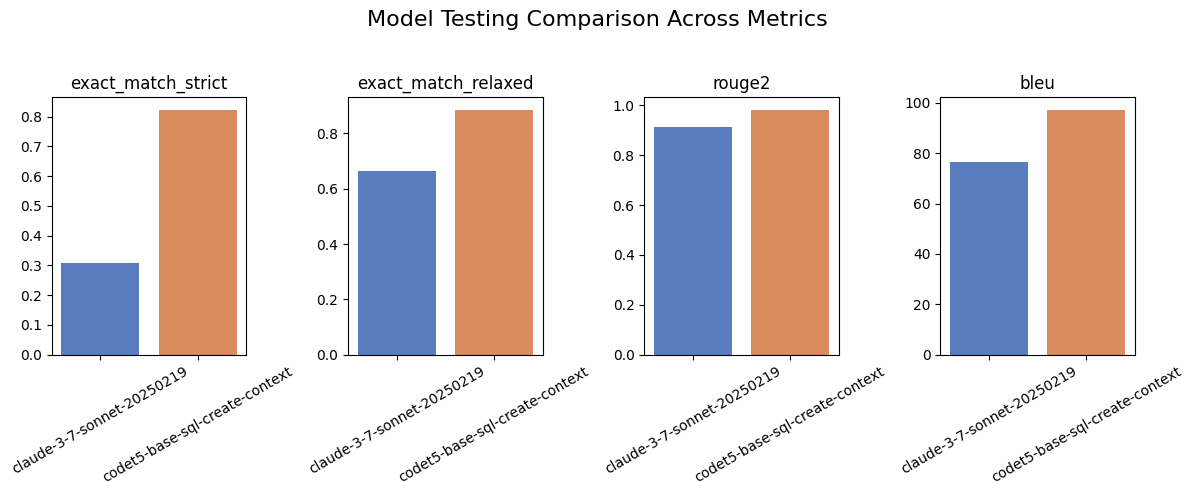

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

t5_new_name = model_info[0]['path']
evaluation_metrics[t5_new_name[10:]] = t5_metrics[t5_new_name]

df = pd.DataFrame(evaluation_metrics).T

# hbar for time taken
plt.figure(figsize=(12, 2))
sns.barplot(x=df.inference_time, y=df.index, orient='h', palette='muted')

plt.title('Testing Time Comparison')
plt.xlabel('Test Data Inference Time (Seconds)')
plt.tight_layout()

# side by side for main metrics
fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=False)

for i, metric in enumerate(df.columns[:4]):
    ax = axes[i]
    subset = df[metric].to_frame()
    sns.barplot(data=subset, x=df.index, y=metric, ax=ax, palette='muted')
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_ylabel('')

plt.suptitle('Model Testing Comparison Across Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [19]:
df

,exact_match_strict,exact_match_relaxed,rouge2,bleu,inference_time
claude-3-7-sonnet-20250219,0.308857,0.663528,0.912577,76.365356,21206.040000
codet5-base-sql-create-context,0.824001,0.886231,0.982541,97.286528,106.530011


In [26]:
t5_results_df = pd.DataFrame(t5_results['test'].to_dict())
sum(t5_results_df['prediction'] == t5_results_df['label']) / len(t5_results_df)

0.8240010180707559

In [27]:
# store the model and maybe push to huggingface hub?
with open("claude_test.json", "w") as f:
    json.dump(evaluation_metrics, f, indent=4)